<a href="https://colab.research.google.com/github/krithika0609/krithika/blob/main/Q_TSFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cirq
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

class QuantumAnomalyOptimizer:
    """Quantum-inspired anomaly detection threshold optimizer using Cirq"""

    def __init__(self, n_qubits: int = 4, n_layers: int = 3):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.simulator = cirq.Simulator()
        self.parameters = self._initialize_parameters()

    def _initialize_parameters(self) -> List[float]:
        """Initialize variational parameters for quantum circuit"""
        return np.random.uniform(0, 2*np.pi, self.n_qubits * self.n_layers * 3).tolist()

    def create_variational_circuit(self, params: List[float], input_data: float) -> cirq.Circuit:
        """Create parameterized quantum circuit for threshold optimization"""
        circuit = cirq.Circuit()
        param_idx = 0

        # Encode input data
        for i, qubit in enumerate(self.qubits):
            circuit.append(cirq.ry(input_data * np.pi / 4)(qubit))

        # Variational layers
        for layer in range(self.n_layers):
            # Rotation gates
            for i, qubit in enumerate(self.qubits):
                circuit.append(cirq.rx(params[param_idx])(qubit))
                param_idx += 1
                circuit.append(cirq.ry(params[param_idx])(qubit))
                param_idx += 1
                circuit.append(cirq.rz(params[param_idx])(qubit))
                param_idx += 1

            # Entangling gates
            for i in range(self.n_qubits - 1):
                circuit.append(cirq.CNOT(self.qubits[i], self.qubits[i+1]))

        return circuit

    def quantum_threshold_function(self, anomaly_score: float, params: List[float]) -> float:
        """Compute quantum-enhanced threshold based on anomaly score"""
        circuit = self.create_variational_circuit(params, anomaly_score)

        # Add measurement
        circuit.append(cirq.measure(self.qubits[0], key='result'))

        # Run quantum circuit
        result = self.simulator.run(circuit, repetitions=100)
        expectation = np.mean(result.measurements['result'])

        # Convert to threshold in [0.3, 0.8] range
        threshold = 0.3 + 0.5 * expectation
        return threshold

    def optimize_threshold(self, anomaly_scores: np.ndarray, true_labels: np.ndarray,
                         n_iterations: int = 50) -> Tuple[float, List[float]]:
        """Quantum annealing-inspired threshold optimization"""
        best_params = self.parameters.copy()
        best_threshold = 0.5
        best_f1 = 0.0

        for iteration in range(n_iterations):
            # Simulated annealing temperature
            temperature = 1.0 / (1.0 + iteration * 0.1)

            # Perturb parameters
            current_params = [p + np.random.normal(0, 0.1 * temperature)
                            for p in self.parameters]

            # Evaluate quantum threshold for each anomaly score
            thresholds = [self.quantum_threshold_function(score, current_params)
                         for score in anomaly_scores[:10]]  # Sample for efficiency

            # Use mean threshold for predictions
            mean_threshold = np.mean(thresholds)
            predictions = (anomaly_scores > mean_threshold).astype(int)

            # Calculate F1 score
            if np.sum(predictions) > 0 and np.sum(true_labels) > 0:
                f1 = f1_score(true_labels, predictions)

                # Accept if better or with probability based on temperature
                if f1 > best_f1 or np.random.random() < np.exp((f1 - best_f1) / temperature):
                    best_f1 = f1
                    best_threshold = mean_threshold
                    best_params = current_params.copy()
                    self.parameters = current_params.copy()

        return best_threshold, best_params

class TransformerTSFM(nn.Module):
    """Transformer-based Time Series Foundation Model"""

    def __init__(self, input_dim: int = 1, d_model: int = 256, nhead: int = 8,
                 num_layers: int = 6, seq_length: int = 168, forecast_horizon: int = 6):
        super(TransformerTSFM, self).__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon

        # Input embedding and positional encoding
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=0.1, activation='gelu', batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Forecast head
        self.forecast_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, forecast_horizon)
        )

        # Anomaly detection head
        self.anomaly_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of the transformer model"""
        batch_size, seq_len, _ = x.shape

        # Input projection and positional encoding
        x = self.input_projection(x)
        x += self.positional_encoding[:seq_len].unsqueeze(0)

        # Transformer encoding
        encoded = self.transformer_encoder(x)

        # Global average pooling for forecast
        pooled = encoded.mean(dim=1)

        # Forecasting
        forecast = self.forecast_head(pooled)

        # Anomaly scores (per timestep)
        anomaly_scores = self.anomaly_head(encoded).squeeze(-1)

        return forecast, anomaly_scores

class BuildingEnergyDataset(Dataset):
    """Dataset class for building energy consumption data"""

    def __init__(self, data: pd.DataFrame, seq_length: int = 168, forecast_horizon: int = 6):
        self.data = data.values
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.scaler = StandardScaler()

        # Normalize data
        self.data = self.scaler.fit_transform(self.data.reshape(-1, 1)).flatten()

    def __len__(self):
        return len(self.data) - self.seq_length - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length:idx + self.seq_length + self.forecast_horizon]

        return torch.FloatTensor(x).unsqueeze(-1), torch.FloatTensor(y)

class ProphetBaseline:
    """Prophet baseline for comparison"""

    def __init__(self):
        self.model = Prophet(
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True
        )

    def fit(self, data: pd.DataFrame):
        """Fit Prophet model"""
        prophet_data = pd.DataFrame({
            'ds': pd.date_range('2020-01-01', periods=len(data), freq='H'),
            'y': data.values.flatten()
        })
        self.model.fit(prophet_data)

    def forecast(self, periods: int) -> np.ndarray:
        """Generate forecast"""
        future = self.model.make_future_dataframe(periods=periods, freq='H')
        forecast = self.model.predict(future)
        return forecast['yhat'].values[-periods:]

class QTSFM:
    """Main Q-TSFM class combining all components"""

    def __init__(self, seq_length: int = 168, forecast_horizon: int = 6):
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize components
        self.tsfm = TransformerTSFM(
            seq_length=seq_length,
            forecast_horizon=forecast_horizon
        ).to(self.device)

        self.quantum_optimizer = QuantumAnomalyOptimizer()
        self.prophet_baseline = ProphetBaseline()

        # Optimizers
        self.optimizer = optim.AdamW(self.tsfm.parameters(), lr=1e-4, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2
        )

    def generate_synthetic_data(self, n_samples: int = 8760) -> Tuple[pd.DataFrame, np.ndarray]:
        """Generate synthetic building energy consumption data"""
        np.random.seed(42)

        # Time series components
        t = np.arange(n_samples)

        # Base load with daily and weekly patterns
        daily_pattern = 10 + 5 * np.sin(2 * np.pi * t / 24) + 3 * np.cos(4 * np.pi * t / 24)
        weekly_pattern = 2 * np.sin(2 * np.pi * t / (24 * 7))

        # Seasonal trends
        seasonal = 3 * np.sin(2 * np.pi * t / (24 * 365))

        # Random noise
        noise = np.random.normal(0, 1, n_samples)

        # Combine components
        energy_consumption = daily_pattern + weekly_pattern + seasonal + noise

        # Add anomalies
        anomaly_labels = np.zeros(n_samples)
        n_anomalies = int(0.05 * n_samples)  # 5% anomalies
        anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)

        for idx in anomaly_indices:
            # Create different types of anomalies
            if np.random.random() > 0.5:
                # Spike anomaly
                energy_consumption[idx] += np.random.uniform(15, 25)
            else:
                # Drop anomaly
                energy_consumption[idx] *= 0.3
            anomaly_labels[idx] = 1

        data = pd.DataFrame({'energy': energy_consumption})
        return data, anomaly_labels

    def train_epoch(self, dataloader: DataLoader) -> Tuple[float, float]:
        """Train one epoch"""
        self.tsfm.train()
        total_forecast_loss = 0.0
        total_anomaly_loss = 0.0

        for batch_idx, (x, y) in enumerate(dataloader):
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            forecast, anomaly_scores = self.tsfm(x)

            # Forecast loss (MSE)
            forecast_loss = F.mse_loss(forecast, y)

            # Anomaly loss (reconstruction-based)
            reconstruction_loss = F.mse_loss(
                anomaly_scores,
                torch.zeros_like(anomaly_scores)
            )

            # Combined loss
            total_loss = forecast_loss + 0.1 * reconstruction_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.tsfm.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_forecast_loss += forecast_loss.item()
            total_anomaly_loss += reconstruction_loss.item()

        return total_forecast_loss / len(dataloader), total_anomaly_loss / len(dataloader)

    def train(self, data: pd.DataFrame, epochs: int = 50, batch_size: int = 32):
        """Train the Q-TSFM model"""
        dataset = BuildingEnergyDataset(data, self.seq_length, self.forecast_horizon)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Train Prophet baseline
        self.prophet_baseline.fit(data)

        train_losses = []

        for epoch in range(epochs):
            forecast_loss, anomaly_loss = self.train_epoch(dataloader)
            self.scheduler.step()

            train_losses.append((forecast_loss, anomaly_loss))

            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Forecast Loss: {forecast_loss:.4f}, "
                      f"Anomaly Loss: {anomaly_loss:.4f}")

        return train_losses

    def predict_and_detect(self, data: pd.DataFrame, true_anomalies: np.ndarray = None) -> Dict:
        """Generate forecasts and detect anomalies"""
        self.tsfm.eval()

        dataset = BuildingEnergyDataset(data, self.seq_length, self.forecast_horizon)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

        forecasts = []
        anomaly_scores = []

        with torch.no_grad():
            for x, _ in dataloader:
                x = x.to(self.device)
                forecast, anomaly_score = self.tsfm(x)

                forecasts.append(forecast.cpu().numpy())
                anomaly_scores.append(anomaly_score.cpu().numpy())

        forecasts = np.array(forecasts)
        anomaly_scores = np.array(anomaly_scores).mean(axis=-1)  # Average over sequence

        # Quantum-optimized threshold
        if true_anomalies is not None:
            # Use only available labels for optimization
            available_labels = true_anomalies[self.seq_length:]
            available_scores = anomaly_scores[:len(available_labels)]

            # Ensure available_scores and available_labels have the same length
            min_len = min(len(available_scores), len(available_labels))
            available_scores = available_scores[:min_len]
            available_labels = available_labels[:min_len]


            optimal_threshold, _ = self.quantum_optimizer.optimize_threshold(
                available_scores, available_labels
            )
        else:
            optimal_threshold = 0.5

        # Detect anomalies
        anomaly_predictions = (anomaly_scores > optimal_threshold).astype(int)

        # Prophet baseline forecast
        prophet_forecast = self.prophet_baseline.forecast(self.forecast_horizon)

        return {
            'tsfm_forecasts': forecasts,
            'prophet_forecasts': prophet_forecast,
            'anomaly_scores': anomaly_scores,
            'anomaly_predictions': anomaly_predictions,
            'optimal_threshold': optimal_threshold
        }

    def evaluate_performance(self, data: pd.DataFrame, true_anomalies: np.ndarray) -> Dict:
        """Evaluate model performance"""
        results = self.predict_and_detect(data, true_anomalies)

        # Forecast evaluation (using last part of data as ground truth)
        tsfm_forecasts_flat = results['tsfm_forecasts'].flatten()
        # Calculate the exact number of forecasted points
        num_forecasted_points = results['tsfm_forecasts'].shape[0] * results['tsfm_forecasts'].shape[1]
        # Slice the ground truth data to match the number of forecasted points
        ground_truth = data.values[self.seq_length : self.seq_length + num_forecasted_points].flatten()

        print(f"Shape of ground_truth: {ground_truth.shape}")
        print(f"Shape of tsfm_forecasts_flat: {tsfm_forecasts_flat.shape}")


        tsfm_mape = mean_absolute_percentage_error(ground_truth, tsfm_forecasts_flat)
        prophet_mape = mean_absolute_percentage_error(data.values[-self.forecast_horizon:], results['prophet_forecasts'])

        # Anomaly detection evaluation
        available_labels = true_anomalies[self.seq_length:len(results['anomaly_predictions']) + self.seq_length]
        anomaly_f1 = f1_score(available_labels, results['anomaly_predictions'])

        return {
            'tsfm_mape': tsfm_mape,
            'prophet_mape': prophet_mape,
            'forecast_improvement': (prophet_mape - tsfm_mape) / prophet_mape * 100,
            'anomaly_f1': anomaly_f1,
            'optimal_threshold': results['optimal_threshold']
        }

# Example usage and demonstration
if __name__ == "__main__":
    print("Q-TSFM: Quantum-Assisted Time Series Foundation Model")
    print("=" * 60)

    # Initialize Q-TSFM
    qtsfm = QTSFM(seq_length=168, forecast_horizon=6)

    # Generate synthetic building energy data
    print("Generating synthetic building energy data...")
    data, anomaly_labels = qtsfm.generate_synthetic_data(n_samples=2000)

    # Split data for training and testing
    train_size = int(0.8 * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    test_anomaly_labels = anomaly_labels[train_size:]

    print(f"Training data: {len(train_data)} samples")
    print(f"Test data: {len(test_data)} samples")

    # Train the model
    print("\nTraining Q-TSFM model...")
    train_losses = qtsfm.train(train_data, epochs=20, batch_size=16)

    # Evaluate performance
    print("\nEvaluating performance...")
    performance = qtsfm.evaluate_performance(test_data, test_anomaly_labels)

    print(f"\nResults:")
    print(f"TSFM MAPE: {performance['tsfm_mape']:.4f}")
    print(f"Prophet MAPE: {performance['prophet_mape']:.4f}")
    print(f"Forecast Improvement: {performance['forecast_improvement']:.2f}%")
    print(f"Anomaly Detection F1: {performance['anomaly_f1']:.4f}")
    print(f"Quantum-Optimized Threshold: {performance['optimal_threshold']:.4f}")

    # Generate predictions for visualization
    results = qtsfm.predict_and_detect(test_data, test_anomaly_labels)

    print(f"\nDetected {np.sum(results['anomaly_predictions'])} anomalies")
    print(f"True anomalies: {np.sum(test_anomaly_labels[qtsfm.seq_length:])}")

    print("\nQ-TSFM implementation complete!")
    print("Key features implemented:")
    print("✓ Transformer-based Time Series Foundation Model")
    print("✓ Quantum-inspired anomaly threshold optimization with Cirq")
    print("✓ Prophet baseline comparison")
    print("✓ Hybrid quantum-classical training pipeline")
    print("✓ Real-time forecasting and anomaly detection")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpskeikhis/mxqsugrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpskeikhis/tgln7swv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12873', 'data', 'file=/tmp/tmpskeikhis/mxqsugrs.json', 'init=/tmp/tmpskeikhis/tgln7swv.json', 'output', 'file=/tmp/tmpskeikhis/prophet_model93fk040o/prophet_model-20250830123120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Q-TSFM: Quantum-Assisted Time Series Foundation Model
Generating synthetic building energy data...
Training data: 1600 samples
Test data: 400 samples

Training Q-TSFM model...


12:31:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 0: Forecast Loss: 0.9050, Anomaly Loss: 0.0422
Epoch 10: Forecast Loss: 0.3591, Anomaly Loss: 0.0002

Evaluating performance...
Shape of ground_truth: (227,)
Shape of tsfm_forecasts_flat: (1362,)


ValueError: Found input variables with inconsistent numbers of samples: [227, 1362]

In [2]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 59.2 MB/s eta 0:00:00


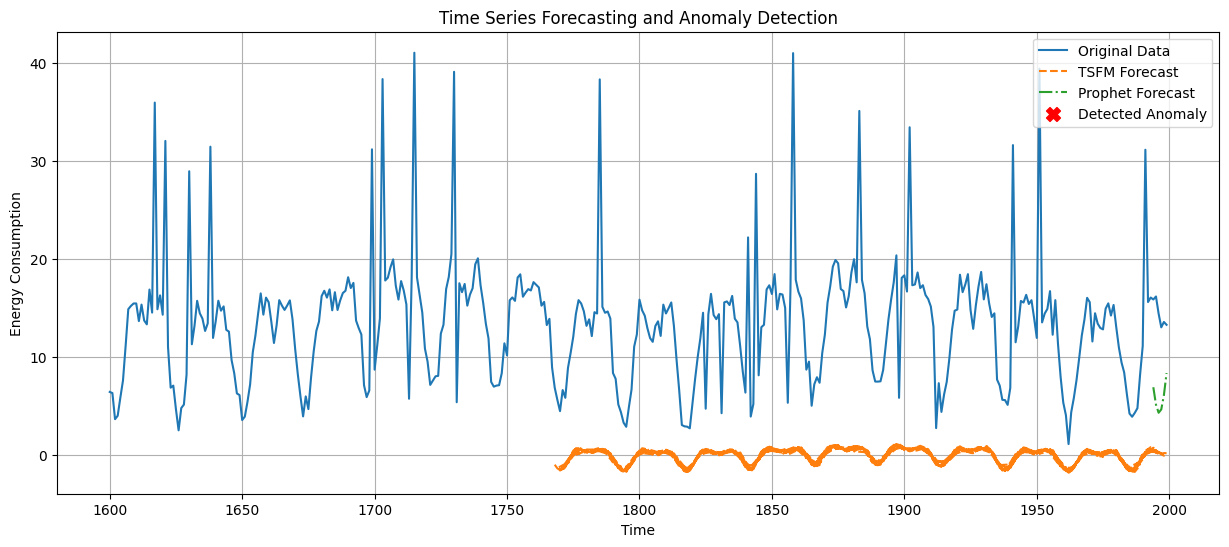

In [17]:
# Generate predictions for visualization
results = qtsfm.predict_and_detect(test_data, test_anomaly_labels)

# Visualize forecasts and anomalies
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data.values, label='Original Data')

# Plot TSFM forecasts - need to align them correctly with the test data index
# The forecasts array shape is (number of sequences, forecast_horizon)
# The index should correspond to the start of the forecast horizon for each sequence
tsfm_forecasts_flat = results['tsfm_forecasts'].flatten()

# Construct the time index for the flattened TSFM forecasts
tsfm_forecast_index_list = []
num_sequences = results['tsfm_forecasts'].shape[0]
for i in range(num_sequences):
    # The forecast for the i-th sequence starts at test_data.index[seq_length + i]
    # and covers the next forecast_horizon points.
    start_index_in_test_data = qtsfm.seq_length + i
    end_index_in_test_data = start_index_in_test_data + qtsfm.forecast_horizon
    tsfm_forecast_index_list.append(test_data.index[start_index_in_test_data : end_index_in_test_data])

tsfm_forecast_index = pd.Index(np.concatenate(tsfm_forecast_index_list))

plt.plot(tsfm_forecast_index, tsfm_forecasts_flat, label='TSFM Forecast', linestyle='--')


# Prophet forecast is for the last `forecast_horizon` periods of the test data
prophet_forecast_index = test_data.index[-qtsfm.forecast_horizon:]
plt.plot(prophet_forecast_index, results['prophet_forecasts'], label='Prophet Forecast', linestyle='-.')

# Plot detected anomalies
anomaly_indices_in_test = np.where(results['anomaly_predictions'] == 1)[0] + qtsfm.seq_length # Adjust index to match test_data index
anomaly_times = test_data.index[anomaly_indices_in_test]
anomaly_values = test_data.values[anomaly_indices_in_test]
plt.scatter(anomaly_times, anomaly_values, color='red', label='Detected Anomaly', marker='X', s=100)

plt.title('Time Series Forecasting and Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()